# Starting

Run the following code to import the modules you'll need. After you finish the assignment, remember to run all cells and convert the notebook to a .pdf file for Gradescope submission.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image
import random
import json

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.12.1+cu116
Torchvision Version:  0.13.1+cu116
Using the GPU!


## Step 0 Part I: Downloading the dataset.


In [ ]:
# download training data
!wget http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip

## Step 0 Part II: Set up some constants and create data loader



In [ ]:
DATA_DIR = "../data/horse2zebra/"
BATCH_SIZE = 1
MSE = nn.MSELoss().cuda()
L1 = nn.L1Loss().cuda()
LEARNING_RATE = 2e-4
IDENTITY_WEIGHT = 10
CYCLE_WEIGHT = 10

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, datatype):
        self.dataPath_A = DATA_DIR+datatype+"A"
        self.dataPath_B = DATA_DIR+datatype+"B"
        self.transform =  A.Compose(
           [A.Resize(width=256, height=256),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
            ToTensorV2(),
            ],
            additional_targets={"image0": "image"},
        )

        self.imageList_A = sorted([os.path.join(self.dataPath_A, f) for f in os.listdir(self.dataPath_A)])
        self.imageList_B = sorted([os.path.join(self.dataPath_B, f) for f in os.listdir(self.dataPath_B)])
        imageLen = min(len(self.imageList_A), 1000)
        imageLen = min(len(self.imageList_B), imageLen)
        self.imageList_A = self.imageList_A[:imageLen]
        self.imageList_B = self.imageList_B[:imageLen]
        self.imageCount_A = len(self.imageList_A)
        self.imageCount_B = len(self.imageList_B)

    def __len__(self):
        return max(len(self.imageList_A), len(self.imageList_B))

    def __getitem__(self, index):
        image_A = self.imageList_A[index % self.imageCount_A]
        image_B = self.imageList_B[index % self.imageCount_A]
        image_A = np.array(Image.open(image_A).convert("RGB"))
        image_B = np.array(Image.open(image_B).convert("RGB"))
        augmentations = self.transform(image=image_A, image0=image_B)
        image_A = augmentations["image"]
        image_B = augmentations["image0"]

        return image_A, image_B


## Step 0 Part III: Visualize training data



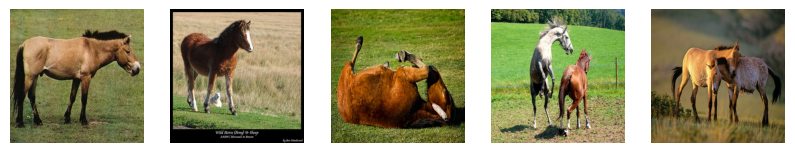

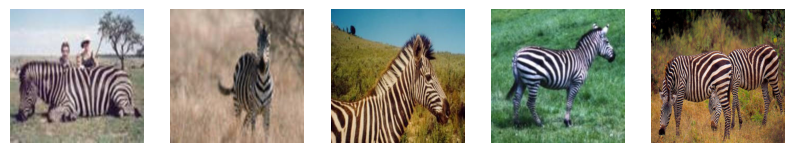

In [ ]:
# visulize training data
testSet = CreateDataset("test")
testLoader = DataLoader(testSet, batch_size = len(testSet))
images = testLoader.__iter__().__next__()

_, axes = plt.subplots(1, 5, figsize=(10, 10))
axes = np.reshape(axes, (5, ))

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

for i in range(5):
  img_A = images[0][i].numpy().transpose((1, 2, 0))
  img_A = std * img_A + mean
  axes[i].imshow(img_A)
  axes[i].axis('off')
plt.show()

_, axes = plt.subplots(1, 5, figsize=(10, 10))
axes = np.reshape(axes, (5, ))
for i in range(5):
  img_B = images[1][i].numpy().transpose((1, 2, 0))
  img_B = std * img_B + mean
  axes[i].imshow(img_B)
  axes[i].axis('off')
plt.show()
#create training data loader
trainSet = CreateDataset("train")
trainLoader = DataLoader(trainSet, batch_size = BATCH_SIZE , pin_memory = True)



## Step 1 Model: Discriminator



In [ ]:
def normal_init(m, mean, std):

    """
    Helper function. Initialize model parameter with given mean and std.
    """
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        # delete start
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        # delete end


class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.ModuleList(
            [nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=True, padding_mode="reflect",),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True, padding_mode="reflect",),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True, padding_mode="reflect",),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=True, padding_mode="reflect",),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=True, padding_mode="reflect",),
            ]
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        for layer in self.conv:
            x = layer(x)
        return torch.sigmoid(x)

#print out discriminator details
x = torch.randn((2, 3, 256, 256))
D = discriminator().to(device)
summary(D,(3, 256, 256))
disc = discriminator()
print(disc(x).shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

## Step 1 Model: Generator



In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,  channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(256, 256, padding_mode="reflect", kernel_size = 3, padding =1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, padding_mode="reflect", kernel_size = 3, padding =1),
            nn.InstanceNorm2d(256),
            nn.Identity(),
        )

    def forward(self, x):
        return x + self.block(x)


class generator(nn.Module):
    def __init__(self, num_residuals=9):
        super().__init__()

        #encoder
        self.encoder = nn.ModuleList(
          [nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
          nn.ReLU(inplace=True),
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, padding_mode="reflect",),
          nn.InstanceNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, padding_mode="reflect",),
          nn.InstanceNorm2d(256),
          nn.ReLU(inplace=True),]
          )

        self.residual = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residuals)]
        )

        #decoder
        self.decoder = nn.ModuleList(
           [nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),]
           )

        self.last = nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


     # forward method
    def forward(self, x):
        # encoding
        for layer in self.encoder:
            x = layer(x)
        #residual
        x = self.residual(x)
        # decoding

        for layer in self.decoder:
            x = layer(x)

        return torch.tanh(self.last(x))

#print out generator details
x = torch.randn((2, 3, 256, 256))
G = generator().to(device)
summary(G,(3, 256, 256))
gen = generator()
print(gen(x).shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-4        [-1, 128, 128, 128]               0
              ReLU-5        [-1, 128, 128, 128]               0
            Conv2d-6          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-7          [-1, 256, 64, 64]               0
              ReLU-8          [-1, 256, 64, 64]               0
            Conv2d-9          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-10          [-1, 256, 64, 64]               0
             ReLU-11          [-1, 256, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
         Identity-14          [-1, 256,

## Step 3 Part I: Save or load model



In [ ]:
def saveModel(gen_A, gen_B, disc_A, disc_B, optGen, optDisc):
    #
    # SAVE training model including optimizer in case of taining is interrupted
    #  model can continue to train
    #
    if SAVE_MODEL is False:
        return
    print("Saving model ....")
    #save generator
    data = {"state_dict": gen_A.state_dict(), "optimizer": optGen.state_dict()}
    torch.save(data, "genA.pth.tar")
    data = {"state_dict": gen_B.state_dict(), "optimizer": None}
    torch.save(data, "genB.pth.tar")
    #save discrimotor
    data = {"state_dict": disc_A.state_dict(), "optimizer": optDisc.state_dict()}
    torch.save(data, "discA.pth.tar")
    data = {"state_dict": disc_B.state_dict(), "optimizer": None}
    torch.save(data, "discB.pth.tar")


def loadModel(gen_A, gen_B, disc_A, disc_B, optGen, optDisc):
    #
    # find out how many epochs already trained
    #
    with open("Lossfile","r") as outfile:
        prevData = json.load(outfile)
        epoch = len(prevData["G_LOSS"])

    print("start epoch {} loading model ....".format(epoch))
    #load generator
    data = torch.load("genA.pth.tar", map_location=device)
    gen_A.load_state_dict(data["state_dict"])
    optGen.load_state_dict(data["optimizer"])
    data = torch.load("genB.pth.tar", map_location=device)
    gen_B.load_state_dict(data["state_dict"])
    #optGen.load_state_dict(data["optimizer"])
    #load discriminator
    data = torch.load("discA.pth.tar", map_location=device)
    disc_A.load_state_dict(data["state_dict"])
    optDisc.load_state_dict(data["optimizer"])
    data = torch.load("discB.pth.tar", map_location=device)
    disc_B.load_state_dict(data["state_dict"])
    #optDisc.load_state_dict(data["optimizer"])

    for param_group in optGen.param_groups:
        param_group["lr"] = LEARNING_RATE
    for param_group in optDisc.param_groups:
        param_group["lr"] = LEARNING_RATE


    return epoch



## Step 3 Part II: train function



In [ ]:

def train(gen_A, gen_B, disc_A, disc_B, optGen, optDisc, sGen, sDisc):
    A_reals = 0
    A_fakes = 0
    G_epoch_loss = 0
    D_epoch_loss = 0
    Cycle_epoch_loss = 0
    Identity_epoch_loss = 0
    loop = tqdm(trainLoader, leave=True)

    for idx, (real_A, real_B) in enumerate(loop):
        A = real_A.to(device)
        B = real_B.to(device)

        # Train Discriminators A and B
        with torch.cuda.amp.autocast():
            fake_A = gen_A(B)
            D_A_real = disc_A(A)
            D_A_fake = disc_A(fake_A.detach())
            A_reals += D_A_real.mean().item()
            A_fakes += D_A_fake.mean().item()
            D_A_real_loss = MSE(D_A_real, torch.ones_like(D_A_real))
            D_A_fake_loss = MSE(D_A_fake, torch.zeros_like(D_A_fake))
            D_A_loss = D_A_real_loss + D_A_fake_loss

            fake_B = gen_B(A)
            D_B_real = disc_B(B)
            D_B_fake = disc_B(fake_B.detach())
            D_B_real_loss = MSE(D_B_real, torch.ones_like(D_B_real))
            D_B_fake_loss = MSE(D_B_fake, torch.zeros_like(D_B_fake))
            D_B_loss = D_B_real_loss + D_B_fake_loss

            # put losses togethor
            D_loss = (D_A_loss + D_B_loss) / 2
            D_epoch_loss += D_loss

        optDisc.zero_grad()
        sDisc.scale(D_loss).backward()
        sDisc.step(optDisc)
        sDisc.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_A_fake = disc_A(fake_A)
            D_B_fake = disc_B(fake_B)
            loss_G_A = MSE(D_A_fake, torch.ones_like(D_A_fake))
            loss_G_B = MSE(D_B_fake, torch.ones_like(D_B_fake))
            genLoss = loss_G_A + loss_G_B

            # cycle loss
            cycle_A = gen_A(fake_B)
            cycle_B = gen_B(fake_A)
            cycleLoss = L1(A, cycle_A) + L1(B, cycle_B)
            Cycle_epoch_loss += cycleLoss

            # identity loss
            identity_A = gen_A(A)
            identity_B = gen_B(B)
            idLoss = L1(A, identity_A) + L1(B, identity_B)
            Identity_epoch_loss += idLoss
            # add all togethor
            G_loss = (genLoss + cycleLoss * CYCLE_WEIGHT + idLoss * IDENTITY_WEIGHT )

            G_epoch_loss += G_loss

        optGen.zero_grad()
        sGen.scale(G_loss).backward()
        sGen.step(optGen)
        sGen.update()

        if idx % 200 == 0:
            save_image(real_A * 0.5 + 0.5, f"saved_images/real_A_{idx}.png")
            save_image(fake_B * 0.5 + 0.5, f"saved_images/fake_B_{idx}.png")
            save_image(cycle_A * 0.5 + 0.5, f"saved_images/cycle_A_{idx}.png")

        loop.set_postfix(A_real=A_reals / (idx + 1), A_fake=A_fakes / (idx + 1))
    # return mean losses for one epoch
    return G_epoch_loss/(idx+1), D_epoch_loss/(idx+1),  Cycle_epoch_loss/(idx+1),  Identity_epoch_loss/(idx+1)



## Step 3 Part III: Validation during traing



In [ ]:
def show_result(gen_A, gen_B, images):
     #validate by test images
    #print 5 real A -> generated B -> generated A
    #print 5 real B -> generated A -> generated B


    _, axes = plt.subplots(5, 3, figsize=(10, 10))
    axes = np.reshape(axes, (15, ))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    for i in range(5):
        real_A = images[0][i]
        fake_B = gen_B(real_A.to(device))
        cycle_A = gen_A(fake_B.to(device))
        real_A = real_A.numpy().transpose((1, 2, 0))
        real_A =  std * real_A + mean
        fake_B = fake_B.cpu().data.numpy().transpose((1, 2, 0))
        fake_B = std * fake_B + mean
        cycle_A = cycle_A.cpu().data.numpy().transpose((1, 2, 0))
        cycle_A = std * cycle_A + mean

        axes[3*i].imshow(real_A)
        axes[3*i].axis('off')
        axes[3*i+1].imshow(fake_B)
        axes[3*i+1].axis('off')
        axes[3*i+2].imshow(cycle_A)
        axes[3*i+2].axis('off')
    plt.show()

    _, axes = plt.subplots(5, 3, figsize=(10, 10))
    axes = np.reshape(axes, (15, ))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    for i in range(5):
        real_B = images[1][i]
        fake_A = gen_A(real_B.to(device))
        cycle_B = gen_B(fake_A.to(device))
        real_B = real_B.numpy().transpose((1, 2, 0))
        real_B =  std * real_B + mean
        fake_A = fake_A.cpu().data.numpy().transpose((1, 2, 0))
        fake_A = std * fake_A + mean
        cycle_B = cycle_B.cpu().data.numpy().transpose((1, 2, 0))
        cycle_B = std * cycle_B + mean

        axes[3*i].imshow(real_B)
        axes[3*i].axis('off')
        axes[3*i+1].imshow(fake_A)
        axes[3*i+1].axis('off')
        axes[3*i+2].imshow(cycle_B)
        axes[3*i+2].axis('off')
    plt.show()



## Step 4 Part III: Training



In [ ]:
#write loss to file
def saveLoss(histLoss_G, histLoss_D, histLoss_C,histLoss_I):
    saveLoss_G = [y.item() for y in histLoss_G]
    saveLoss_D = [y.item() for y in histLoss_D]
    saveLoss_C = [y.item() for y in histLoss_C]
    saveLoss_I = [y.item() for y in histLoss_I]


    if LOAD_MODEL:
        with open("Lossfile","r") as outfile:
            prevData = json.load(outfile)
            saveLoss_G = prevData["G_LOSS"] + saveLoss_G
            saveLoss_D = prevData["D_LOSS"] + saveLoss_D
            saveLoss_C = prevData["C_LOSS"] + saveLoss_C
            saveLoss_I = prevData["I_LOSS"] + saveLoss_I

    lossData = {"G_LOSS": saveLoss_G, "D_LOSS": saveLoss_D, "C_LOSS": saveLoss_C, "I_LOSS": saveLoss_I}
    with open("Lossfile","w") as outfile:
        json.dump(lossData, outfile, indent=4)


start epoch 100 loading model ....


100%|████████████| 1000/1000 [02:13<00:00,  7.47it/s, A_fake=0.32, A_real=0.679]


[101/200] - using time: 134.45 seconds
loss of discriminator D: 3.279, generator G: 0.310 , cycle consistency: 0.121, identity consistency: 0.071
Saving model ....


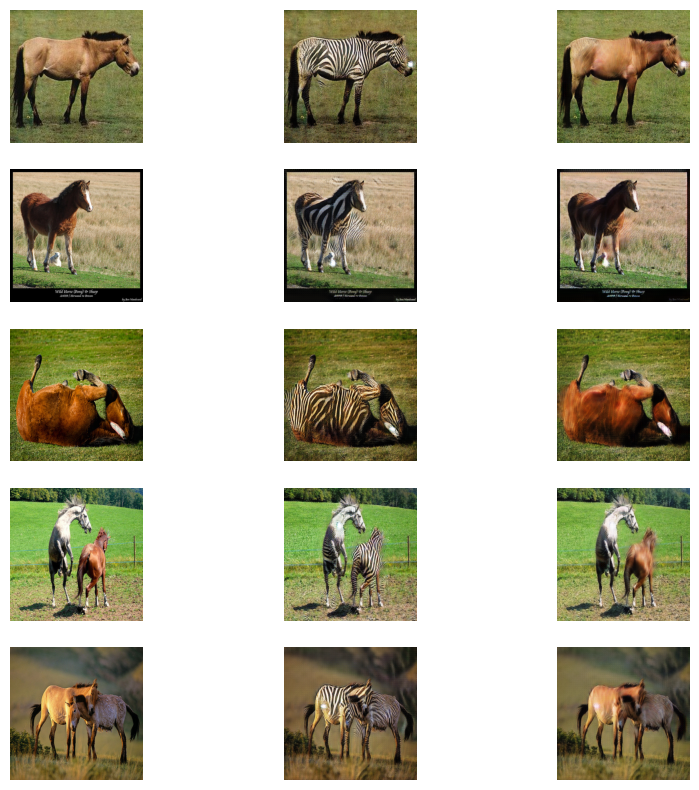

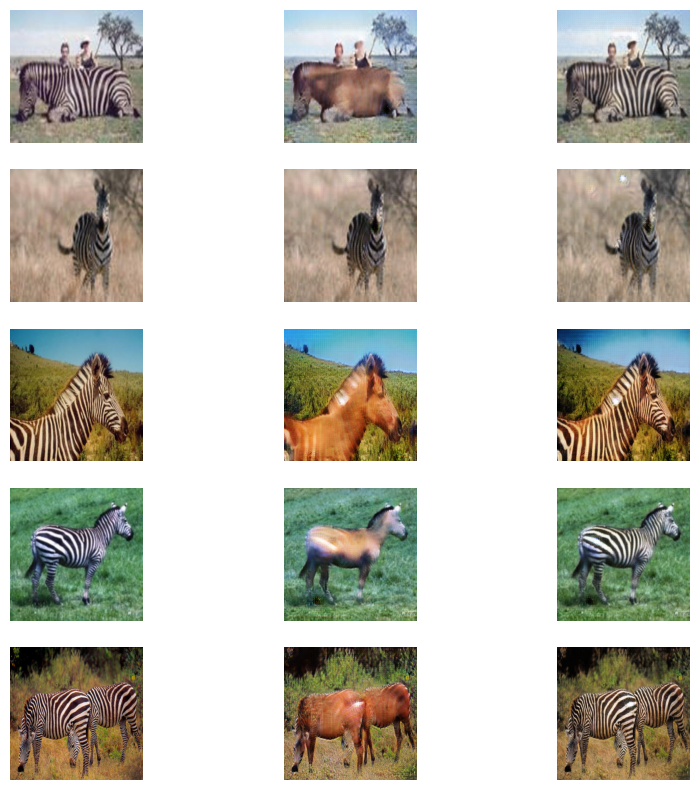

100%|███████████| 1000/1000 [01:59<00:00,  8.36it/s, A_fake=0.325, A_real=0.672]


[102/200] - using time: 120.21 seconds
loss of discriminator D: 3.233, generator G: 0.320 , cycle consistency: 0.120, identity consistency: 0.070
Saving model ....
Epoch 102: adam lr 0.000200 -> 0.000198


100%|███████████| 1000/1000 [01:57<00:00,  8.48it/s, A_fake=0.323, A_real=0.672]


[103/200] - using time: 118.53 seconds
loss of discriminator D: 3.232, generator G: 0.317 , cycle consistency: 0.120, identity consistency: 0.069
Saving model ....
Epoch 103: adam lr 0.000198 -> 0.000196


100%|███████████| 1000/1000 [01:56<00:00,  8.56it/s, A_fake=0.324, A_real=0.674]


[104/200] - using time: 117.45 seconds
loss of discriminator D: 3.229, generator G: 0.316 , cycle consistency: 0.119, identity consistency: 0.069
Saving model ....
Epoch 104: adam lr 0.000196 -> 0.000194


100%|███████████| 1000/1000 [01:56<00:00,  8.61it/s, A_fake=0.323, A_real=0.674]


[105/200] - using time: 116.80 seconds
loss of discriminator D: 3.212, generator G: 0.314 , cycle consistency: 0.118, identity consistency: 0.069
Saving model ....
Epoch 105: adam lr 0.000194 -> 0.000192


100%|███████████| 1000/1000 [01:57<00:00,  8.53it/s, A_fake=0.321, A_real=0.674]


[106/200] - using time: 117.88 seconds
loss of discriminator D: 3.209, generator G: 0.312 , cycle consistency: 0.118, identity consistency: 0.069
Saving model ....
Epoch 106: adam lr 0.000192 -> 0.000190


100%|███████████| 1000/1000 [01:58<00:00,  8.42it/s, A_fake=0.325, A_real=0.672]


[107/200] - using time: 119.48 seconds
loss of discriminator D: 3.189, generator G: 0.315 , cycle consistency: 0.118, identity consistency: 0.068
Saving model ....
Epoch 107: adam lr 0.000190 -> 0.000188


100%|███████████| 1000/1000 [01:54<00:00,  8.73it/s, A_fake=0.316, A_real=0.684]


[108/200] - using time: 115.21 seconds
loss of discriminator D: 3.214, generator G: 0.306 , cycle consistency: 0.118, identity consistency: 0.068
Saving model ....
Epoch 108: adam lr 0.000188 -> 0.000186


100%|███████████| 1000/1000 [01:55<00:00,  8.62it/s, A_fake=0.322, A_real=0.675]


[109/200] - using time: 116.68 seconds
loss of discriminator D: 3.203, generator G: 0.312 , cycle consistency: 0.118, identity consistency: 0.068
Saving model ....
Epoch 109: adam lr 0.000186 -> 0.000184


100%|███████████| 1000/1000 [01:57<00:00,  8.52it/s, A_fake=0.324, A_real=0.675]


[110/200] - using time: 117.97 seconds
loss of discriminator D: 3.182, generator G: 0.311 , cycle consistency: 0.117, identity consistency: 0.067
Saving model ....
Epoch 110: adam lr 0.000184 -> 0.000182


100%|███████████| 1000/1000 [01:54<00:00,  8.72it/s, A_fake=0.324, A_real=0.674]


[111/200] - using time: 115.33 seconds
loss of discriminator D: 3.176, generator G: 0.309 , cycle consistency: 0.117, identity consistency: 0.067
Saving model ....
Epoch 111: adam lr 0.000182 -> 0.000180


100%|███████████| 1000/1000 [01:54<00:00,  8.71it/s, A_fake=0.327, A_real=0.671]


[112/200] - using time: 115.41 seconds
loss of discriminator D: 3.160, generator G: 0.314 , cycle consistency: 0.116, identity consistency: 0.066
Saving model ....
Epoch 112: adam lr 0.000180 -> 0.000178


100%|███████████| 1000/1000 [01:53<00:00,  8.81it/s, A_fake=0.324, A_real=0.672]


[113/200] - using time: 114.24 seconds
loss of discriminator D: 3.166, generator G: 0.311 , cycle consistency: 0.117, identity consistency: 0.066
Saving model ....
Epoch 113: adam lr 0.000178 -> 0.000176


100%|███████████| 1000/1000 [01:53<00:00,  8.80it/s, A_fake=0.327, A_real=0.672]


[114/200] - using time: 114.30 seconds
loss of discriminator D: 3.141, generator G: 0.315 , cycle consistency: 0.115, identity consistency: 0.066
Saving model ....
Epoch 114: adam lr 0.000176 -> 0.000174


100%|███████████| 1000/1000 [01:54<00:00,  8.73it/s, A_fake=0.325, A_real=0.675]


[115/200] - using time: 115.25 seconds
loss of discriminator D: 3.144, generator G: 0.309 , cycle consistency: 0.115, identity consistency: 0.066
Saving model ....
Epoch 115: adam lr 0.000174 -> 0.000172


100%|████████████| 1000/1000 [01:53<00:00,  8.77it/s, A_fake=0.326, A_real=0.67]


[116/200] - using time: 114.63 seconds
loss of discriminator D: 3.151, generator G: 0.311 , cycle consistency: 0.116, identity consistency: 0.065
Saving model ....
Epoch 116: adam lr 0.000172 -> 0.000170


100%|███████████| 1000/1000 [01:53<00:00,  8.79it/s, A_fake=0.321, A_real=0.676]


[117/200] - using time: 114.43 seconds
loss of discriminator D: 3.143, generator G: 0.306 , cycle consistency: 0.115, identity consistency: 0.065
Saving model ....
Epoch 117: adam lr 0.000170 -> 0.000168


100%|████████████| 1000/1000 [01:53<00:00,  8.81it/s, A_fake=0.318, A_real=0.68]


[118/200] - using time: 114.19 seconds
loss of discriminator D: 3.147, generator G: 0.301 , cycle consistency: 0.115, identity consistency: 0.065
Saving model ....
Epoch 118: adam lr 0.000168 -> 0.000166


100%|███████████| 1000/1000 [01:53<00:00,  8.81it/s, A_fake=0.302, A_real=0.699]


[119/200] - using time: 114.28 seconds
loss of discriminator D: 3.148, generator G: 0.290 , cycle consistency: 0.113, identity consistency: 0.065
Saving model ....
Epoch 119: adam lr 0.000166 -> 0.000164


100%|███████████| 1000/1000 [01:53<00:00,  8.81it/s, A_fake=0.325, A_real=0.673]


[120/200] - using time: 114.18 seconds
loss of discriminator D: 3.111, generator G: 0.308 , cycle consistency: 0.114, identity consistency: 0.064
Saving model ....
Epoch 120: adam lr 0.000164 -> 0.000162


100%|███████████| 1000/1000 [01:53<00:00,  8.81it/s, A_fake=0.322, A_real=0.675]


[121/200] - using time: 114.22 seconds
loss of discriminator D: 3.114, generator G: 0.305 , cycle consistency: 0.114, identity consistency: 0.064
Saving model ....
Epoch 121: adam lr 0.000162 -> 0.000160


100%|███████████| 1000/1000 [01:54<00:00,  8.73it/s, A_fake=0.324, A_real=0.673]


[122/200] - using time: 115.27 seconds
loss of discriminator D: 3.098, generator G: 0.309 , cycle consistency: 0.114, identity consistency: 0.063
Saving model ....
Epoch 122: adam lr 0.000160 -> 0.000158


100%|███████████| 1000/1000 [01:54<00:00,  8.77it/s, A_fake=0.323, A_real=0.676]


[123/200] - using time: 114.78 seconds
loss of discriminator D: 3.095, generator G: 0.305 , cycle consistency: 0.113, identity consistency: 0.063
Saving model ....
Epoch 123: adam lr 0.000158 -> 0.000156


100%|███████████| 1000/1000 [01:53<00:00,  8.78it/s, A_fake=0.324, A_real=0.675]


[124/200] - using time: 114.59 seconds
loss of discriminator D: 3.087, generator G: 0.308 , cycle consistency: 0.114, identity consistency: 0.063
Saving model ....
Epoch 124: adam lr 0.000156 -> 0.000154


100%|███████████| 1000/1000 [01:53<00:00,  8.78it/s, A_fake=0.325, A_real=0.675]


[125/200] - using time: 114.64 seconds
loss of discriminator D: 3.074, generator G: 0.308 , cycle consistency: 0.113, identity consistency: 0.062
Saving model ....
Epoch 125: adam lr 0.000154 -> 0.000152


100%|███████████| 1000/1000 [01:54<00:00,  8.70it/s, A_fake=0.324, A_real=0.675]


[126/200] - using time: 115.71 seconds
loss of discriminator D: 3.073, generator G: 0.304 , cycle consistency: 0.113, identity consistency: 0.062
Saving model ....
Epoch 126: adam lr 0.000152 -> 0.000150


100%|███████████| 1000/1000 [01:54<00:00,  8.75it/s, A_fake=0.323, A_real=0.677]


[127/200] - using time: 115.08 seconds
loss of discriminator D: 3.078, generator G: 0.302 , cycle consistency: 0.113, identity consistency: 0.062
Saving model ....
Epoch 127: adam lr 0.000150 -> 0.000149


100%|███████████| 1000/1000 [01:53<00:00,  8.82it/s, A_fake=0.325, A_real=0.673]


[128/200] - using time: 114.17 seconds
loss of discriminator D: 3.057, generator G: 0.311 , cycle consistency: 0.112, identity consistency: 0.062
Saving model ....
Epoch 128: adam lr 0.000149 -> 0.000147


100%|███████████| 1000/1000 [01:54<00:00,  8.75it/s, A_fake=0.323, A_real=0.677]


[129/200] - using time: 115.01 seconds
loss of discriminator D: 3.061, generator G: 0.307 , cycle consistency: 0.113, identity consistency: 0.062
Saving model ....
Epoch 129: adam lr 0.000147 -> 0.000145


100%|███████████| 1000/1000 [01:53<00:00,  8.81it/s, A_fake=0.321, A_real=0.677]


[130/200] - using time: 114.29 seconds
loss of discriminator D: 3.067, generator G: 0.303 , cycle consistency: 0.113, identity consistency: 0.062
Saving model ....
Epoch 130: adam lr 0.000145 -> 0.000143


100%|███████████| 1000/1000 [01:53<00:00,  8.81it/s, A_fake=0.325, A_real=0.672]


[131/200] - using time: 114.31 seconds
loss of discriminator D: 3.044, generator G: 0.308 , cycle consistency: 0.112, identity consistency: 0.061
Saving model ....
Epoch 131: adam lr 0.000143 -> 0.000141


100%|███████████| 1000/1000 [01:53<00:00,  8.80it/s, A_fake=0.325, A_real=0.675]


[132/200] - using time: 114.39 seconds
loss of discriminator D: 3.033, generator G: 0.308 , cycle consistency: 0.112, identity consistency: 0.061
Saving model ....
Epoch 132: adam lr 0.000141 -> 0.000139


100%|███████████| 1000/1000 [01:54<00:00,  8.76it/s, A_fake=0.324, A_real=0.673]


[133/200] - using time: 114.98 seconds
loss of discriminator D: 3.026, generator G: 0.308 , cycle consistency: 0.111, identity consistency: 0.061
Saving model ....
Epoch 133: adam lr 0.000139 -> 0.000137


100%|███████████| 1000/1000 [01:55<00:00,  8.65it/s, A_fake=0.328, A_real=0.672]


[134/200] - using time: 116.42 seconds
loss of discriminator D: 3.014, generator G: 0.311 , cycle consistency: 0.111, identity consistency: 0.060
Saving model ....
Epoch 134: adam lr 0.000137 -> 0.000135


100%|███████████| 1000/1000 [01:55<00:00,  8.64it/s, A_fake=0.327, A_real=0.673]


[135/200] - using time: 116.52 seconds
loss of discriminator D: 3.015, generator G: 0.310 , cycle consistency: 0.112, identity consistency: 0.060
Saving model ....
Epoch 135: adam lr 0.000135 -> 0.000133


100%|████████████| 1000/1000 [01:54<00:00,  8.70it/s, A_fake=0.325, A_real=0.67]


[136/200] - using time: 115.71 seconds
loss of discriminator D: 3.015, generator G: 0.309 , cycle consistency: 0.112, identity consistency: 0.060
Saving model ....
Epoch 136: adam lr 0.000133 -> 0.000131


100%|███████████| 1000/1000 [01:54<00:00,  8.75it/s, A_fake=0.327, A_real=0.672]


[137/200] - using time: 115.10 seconds
loss of discriminator D: 2.996, generator G: 0.315 , cycle consistency: 0.111, identity consistency: 0.060
Saving model ....
Epoch 137: adam lr 0.000131 -> 0.000129


100%|████████████| 1000/1000 [01:54<00:00,  8.77it/s, A_fake=0.328, A_real=0.67]


[138/200] - using time: 114.88 seconds
loss of discriminator D: 2.981, generator G: 0.316 , cycle consistency: 0.111, identity consistency: 0.059
Saving model ....
Epoch 138: adam lr 0.000129 -> 0.000127


100%|████████████| 1000/1000 [01:54<00:00,  8.72it/s, A_fake=0.327, A_real=0.67]


[139/200] - using time: 115.56 seconds
loss of discriminator D: 2.979, generator G: 0.314 , cycle consistency: 0.111, identity consistency: 0.059
Saving model ....
Epoch 139: adam lr 0.000127 -> 0.000125


100%|███████████| 1000/1000 [01:54<00:00,  8.72it/s, A_fake=0.328, A_real=0.669]


[140/200] - using time: 115.44 seconds
loss of discriminator D: 2.970, generator G: 0.312 , cycle consistency: 0.111, identity consistency: 0.059
Saving model ....
Epoch 140: adam lr 0.000125 -> 0.000123


100%|████████████| 1000/1000 [01:54<00:00,  8.71it/s, A_fake=0.329, A_real=0.67]


[141/200] - using time: 115.60 seconds
loss of discriminator D: 2.963, generator G: 0.313 , cycle consistency: 0.111, identity consistency: 0.059
Saving model ....
Epoch 141: adam lr 0.000123 -> 0.000121


100%|████████████| 1000/1000 [01:56<00:00,  8.58it/s, A_fake=0.327, A_real=0.67]


[142/200] - using time: 117.37 seconds
loss of discriminator D: 2.958, generator G: 0.316 , cycle consistency: 0.111, identity consistency: 0.059
Saving model ....
Epoch 142: adam lr 0.000121 -> 0.000119


100%|███████████| 1000/1000 [01:56<00:00,  8.61it/s, A_fake=0.329, A_real=0.669]


[143/200] - using time: 117.03 seconds
loss of discriminator D: 2.941, generator G: 0.317 , cycle consistency: 0.110, identity consistency: 0.058
Saving model ....
Epoch 143: adam lr 0.000119 -> 0.000117


100%|███████████| 1000/1000 [01:56<00:00,  8.60it/s, A_fake=0.333, A_real=0.666]


[144/200] - using time: 117.19 seconds
loss of discriminator D: 2.931, generator G: 0.320 , cycle consistency: 0.110, identity consistency: 0.058
Saving model ....
Epoch 144: adam lr 0.000117 -> 0.000115


100%|███████████| 1000/1000 [01:56<00:00,  8.59it/s, A_fake=0.332, A_real=0.666]


[145/200] - using time: 117.25 seconds
loss of discriminator D: 2.924, generator G: 0.317 , cycle consistency: 0.109, identity consistency: 0.058
Saving model ....
Epoch 145: adam lr 0.000115 -> 0.000113


100%|███████████| 1000/1000 [01:54<00:00,  8.72it/s, A_fake=0.329, A_real=0.668]


[146/200] - using time: 115.60 seconds
loss of discriminator D: 2.921, generator G: 0.318 , cycle consistency: 0.109, identity consistency: 0.058
Saving model ....
Epoch 146: adam lr 0.000113 -> 0.000111


100%|███████████| 1000/1000 [01:56<00:00,  8.60it/s, A_fake=0.329, A_real=0.669]


[147/200] - using time: 117.13 seconds
loss of discriminator D: 2.914, generator G: 0.318 , cycle consistency: 0.109, identity consistency: 0.057
Saving model ....
Epoch 147: adam lr 0.000111 -> 0.000109


100%|███████████| 1000/1000 [01:56<00:00,  8.55it/s, A_fake=0.336, A_real=0.662]


[148/200] - using time: 117.83 seconds
loss of discriminator D: 2.890, generator G: 0.323 , cycle consistency: 0.109, identity consistency: 0.057
Saving model ....
Epoch 148: adam lr 0.000109 -> 0.000107


100%|███████████| 1000/1000 [01:56<00:00,  8.55it/s, A_fake=0.331, A_real=0.666]


[149/200] - using time: 117.90 seconds
loss of discriminator D: 2.893, generator G: 0.321 , cycle consistency: 0.109, identity consistency: 0.057
Saving model ....
Epoch 149: adam lr 0.000107 -> 0.000105


100%|███████████| 1000/1000 [01:56<00:00,  8.56it/s, A_fake=0.334, A_real=0.665]


[150/200] - using time: 117.79 seconds
loss of discriminator D: 2.871, generator G: 0.325 , cycle consistency: 0.108, identity consistency: 0.057
Saving model ....
Epoch 150: adam lr 0.000105 -> 0.000103


100%|███████████| 1000/1000 [01:56<00:00,  8.57it/s, A_fake=0.335, A_real=0.662]


[151/200] - using time: 117.66 seconds
loss of discriminator D: 2.867, generator G: 0.325 , cycle consistency: 0.108, identity consistency: 0.057
Saving model ....


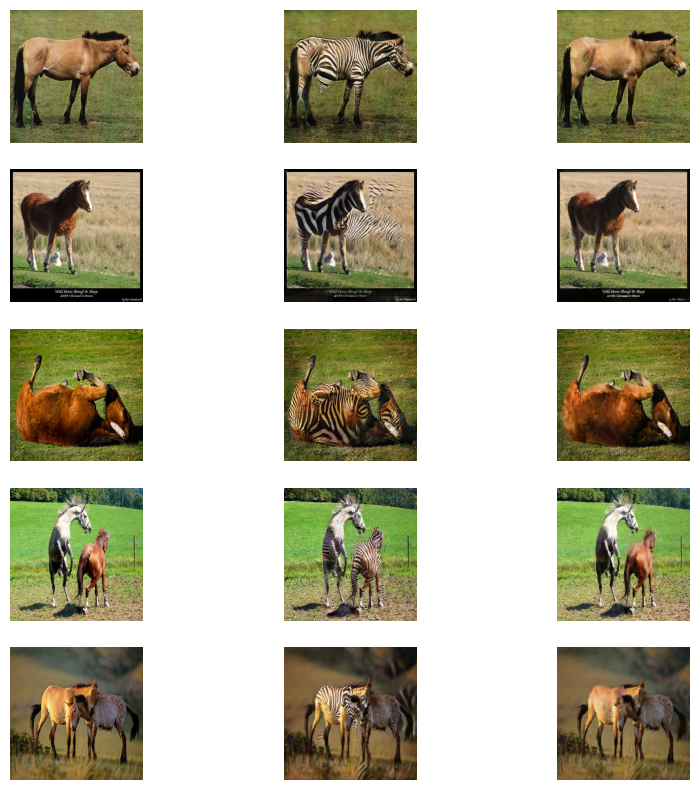

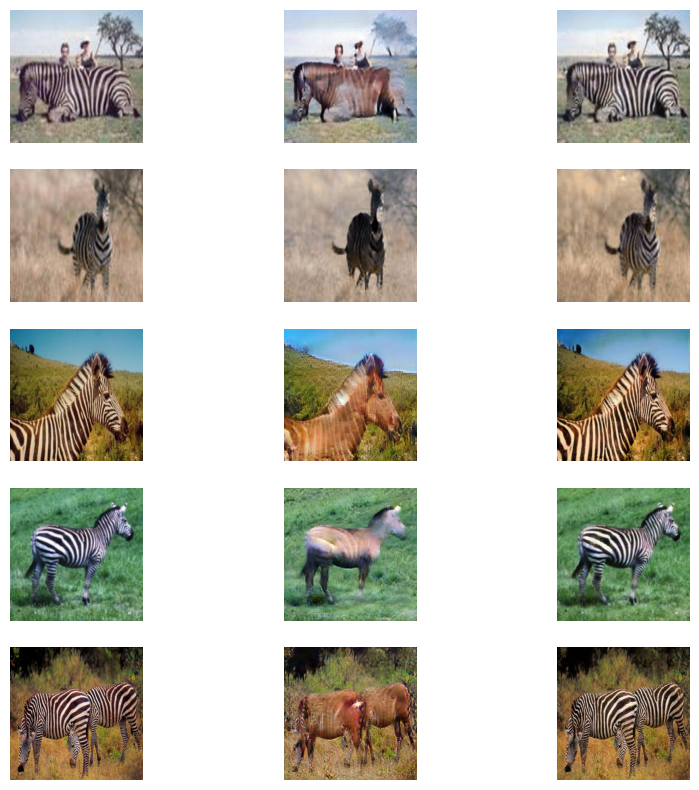

Epoch 151: adam lr 0.000103 -> 0.000101


100%|███████████| 1000/1000 [01:56<00:00,  8.61it/s, A_fake=0.336, A_real=0.661]


[152/200] - using time: 116.98 seconds
loss of discriminator D: 2.858, generator G: 0.326 , cycle consistency: 0.108, identity consistency: 0.056
Saving model ....
Epoch 152: adam lr 0.000101 -> 0.000099


100%|████████████| 1000/1000 [01:56<00:00,  8.61it/s, A_fake=0.335, A_real=0.66]


[153/200] - using time: 117.01 seconds
loss of discriminator D: 2.846, generator G: 0.329 , cycle consistency: 0.108, identity consistency: 0.056
Saving model ....
Epoch 153: adam lr 0.000099 -> 0.000097


100%|███████████| 1000/1000 [01:56<00:00,  8.56it/s, A_fake=0.336, A_real=0.662]


[154/200] - using time: 117.66 seconds
loss of discriminator D: 2.839, generator G: 0.327 , cycle consistency: 0.108, identity consistency: 0.056
Saving model ....
Epoch 154: adam lr 0.000097 -> 0.000095


100%|███████████| 1000/1000 [01:57<00:00,  8.52it/s, A_fake=0.336, A_real=0.663]


[155/200] - using time: 118.24 seconds
loss of discriminator D: 2.834, generator G: 0.325 , cycle consistency: 0.107, identity consistency: 0.056
Saving model ....
Epoch 155: adam lr 0.000095 -> 0.000093


100%|███████████| 1000/1000 [01:57<00:00,  8.51it/s, A_fake=0.332, A_real=0.665]


[156/200] - using time: 118.48 seconds
loss of discriminator D: 2.827, generator G: 0.325 , cycle consistency: 0.107, identity consistency: 0.056
Saving model ....
Epoch 156: adam lr 0.000093 -> 0.000091


100%|███████████| 1000/1000 [01:57<00:00,  8.54it/s, A_fake=0.336, A_real=0.661]


[157/200] - using time: 118.02 seconds
loss of discriminator D: 2.811, generator G: 0.330 , cycle consistency: 0.107, identity consistency: 0.055
Saving model ....
Epoch 157: adam lr 0.000091 -> 0.000089


100%|███████████| 1000/1000 [01:56<00:00,  8.55it/s, A_fake=0.338, A_real=0.657]


[158/200] - using time: 117.80 seconds
loss of discriminator D: 2.801, generator G: 0.332 , cycle consistency: 0.107, identity consistency: 0.055
Saving model ....
Epoch 158: adam lr 0.000089 -> 0.000087


100%|███████████| 1000/1000 [01:56<00:00,  8.61it/s, A_fake=0.335, A_real=0.662]


[159/200] - using time: 117.08 seconds
loss of discriminator D: 2.797, generator G: 0.329 , cycle consistency: 0.107, identity consistency: 0.055
Saving model ....
Epoch 159: adam lr 0.000087 -> 0.000085


100%|███████████| 1000/1000 [01:56<00:00,  8.56it/s, A_fake=0.341, A_real=0.658]


[160/200] - using time: 117.75 seconds
loss of discriminator D: 2.782, generator G: 0.332 , cycle consistency: 0.107, identity consistency: 0.055
Saving model ....
Epoch 160: adam lr 0.000085 -> 0.000083


100%|███████████| 1000/1000 [01:56<00:00,  8.59it/s, A_fake=0.339, A_real=0.657]


[161/200] - using time: 117.35 seconds
loss of discriminator D: 2.770, generator G: 0.334 , cycle consistency: 0.106, identity consistency: 0.055
Saving model ....
Epoch 161: adam lr 0.000083 -> 0.000081


100%|███████████| 1000/1000 [01:57<00:00,  8.53it/s, A_fake=0.341, A_real=0.658]


[162/200] - using time: 118.11 seconds
loss of discriminator D: 2.768, generator G: 0.333 , cycle consistency: 0.106, identity consistency: 0.054
Saving model ....
Epoch 162: adam lr 0.000081 -> 0.000079


100%|████████████| 1000/1000 [01:56<00:00,  8.60it/s, A_fake=0.34, A_real=0.658]


[163/200] - using time: 117.19 seconds
loss of discriminator D: 2.758, generator G: 0.334 , cycle consistency: 0.106, identity consistency: 0.054
Saving model ....
Epoch 163: adam lr 0.000079 -> 0.000077


100%|████████████| 1000/1000 [01:55<00:00,  8.64it/s, A_fake=0.34, A_real=0.656]


[164/200] - using time: 116.57 seconds
loss of discriminator D: 2.748, generator G: 0.336 , cycle consistency: 0.106, identity consistency: 0.054
Saving model ....
Epoch 164: adam lr 0.000077 -> 0.000075


100%|███████████| 1000/1000 [01:55<00:00,  8.66it/s, A_fake=0.342, A_real=0.656]


[165/200] - using time: 116.43 seconds
loss of discriminator D: 2.745, generator G: 0.333 , cycle consistency: 0.106, identity consistency: 0.054
Saving model ....
Epoch 165: adam lr 0.000075 -> 0.000073


100%|███████████| 1000/1000 [01:56<00:00,  8.58it/s, A_fake=0.342, A_real=0.655]


[166/200] - using time: 117.44 seconds
loss of discriminator D: 2.726, generator G: 0.336 , cycle consistency: 0.105, identity consistency: 0.054
Saving model ....
Epoch 166: adam lr 0.000073 -> 0.000071


100%|███████████| 1000/1000 [01:57<00:00,  8.54it/s, A_fake=0.343, A_real=0.653]


[167/200] - using time: 118.08 seconds
loss of discriminator D: 2.710, generator G: 0.340 , cycle consistency: 0.105, identity consistency: 0.053
Saving model ....
Epoch 167: adam lr 0.000071 -> 0.000069


100%|███████████| 1000/1000 [01:57<00:00,  8.52it/s, A_fake=0.341, A_real=0.655]


[168/200] - using time: 118.23 seconds
loss of discriminator D: 2.715, generator G: 0.337 , cycle consistency: 0.105, identity consistency: 0.054
Saving model ....
Epoch 168: adam lr 0.000069 -> 0.000067


100%|████████████| 1000/1000 [01:57<00:00,  8.50it/s, A_fake=0.344, A_real=0.65]


[169/200] - using time: 118.55 seconds
loss of discriminator D: 2.701, generator G: 0.340 , cycle consistency: 0.105, identity consistency: 0.053
Saving model ....
Epoch 169: adam lr 0.000067 -> 0.000065


100%|████████████| 1000/1000 [01:57<00:00,  8.50it/s, A_fake=0.345, A_real=0.65]


[170/200] - using time: 118.61 seconds
loss of discriminator D: 2.689, generator G: 0.341 , cycle consistency: 0.105, identity consistency: 0.053
Saving model ....
Epoch 170: adam lr 0.000065 -> 0.000063


100%|████████████| 1000/1000 [01:57<00:00,  8.51it/s, A_fake=0.345, A_real=0.65]


[171/200] - using time: 118.45 seconds
loss of discriminator D: 2.684, generator G: 0.340 , cycle consistency: 0.105, identity consistency: 0.053
Saving model ....
Epoch 171: adam lr 0.000063 -> 0.000061


100%|███████████| 1000/1000 [01:57<00:00,  8.49it/s, A_fake=0.348, A_real=0.646]


[172/200] - using time: 118.64 seconds
loss of discriminator D: 2.669, generator G: 0.343 , cycle consistency: 0.104, identity consistency: 0.053
Saving model ....
Epoch 172: adam lr 0.000061 -> 0.000059


100%|████████████| 1000/1000 [01:58<00:00,  8.47it/s, A_fake=0.35, A_real=0.645]


[173/200] - using time: 119.00 seconds
loss of discriminator D: 2.660, generator G: 0.344 , cycle consistency: 0.104, identity consistency: 0.053
Saving model ....
Epoch 173: adam lr 0.000059 -> 0.000057


100%|████████████| 1000/1000 [01:57<00:00,  8.49it/s, A_fake=0.35, A_real=0.646]


[174/200] - using time: 118.73 seconds
loss of discriminator D: 2.648, generator G: 0.346 , cycle consistency: 0.104, identity consistency: 0.052
Saving model ....
Epoch 174: adam lr 0.000057 -> 0.000055


100%|███████████| 1000/1000 [01:58<00:00,  8.47it/s, A_fake=0.351, A_real=0.643]


[175/200] - using time: 119.03 seconds
loss of discriminator D: 2.640, generator G: 0.347 , cycle consistency: 0.104, identity consistency: 0.052
Saving model ....
Epoch 175: adam lr 0.000055 -> 0.000053


100%|███████████| 1000/1000 [01:58<00:00,  8.46it/s, A_fake=0.353, A_real=0.641]


[176/200] - using time: 119.18 seconds
loss of discriminator D: 2.626, generator G: 0.350 , cycle consistency: 0.104, identity consistency: 0.052
Saving model ....
Epoch 176: adam lr 0.000053 -> 0.000051


100%|███████████| 1000/1000 [01:58<00:00,  8.45it/s, A_fake=0.354, A_real=0.639]


[177/200] - using time: 119.33 seconds
loss of discriminator D: 2.619, generator G: 0.350 , cycle consistency: 0.104, identity consistency: 0.052
Saving model ....
Epoch 177: adam lr 0.000051 -> 0.000050


100%|███████████| 1000/1000 [01:58<00:00,  8.45it/s, A_fake=0.355, A_real=0.638]


[178/200] - using time: 119.25 seconds
loss of discriminator D: 2.607, generator G: 0.352 , cycle consistency: 0.103, identity consistency: 0.052
Saving model ....
Epoch 178: adam lr 0.000050 -> 0.000048


100%|███████████| 1000/1000 [01:59<00:00,  8.40it/s, A_fake=0.354, A_real=0.639]


[179/200] - using time: 120.03 seconds
loss of discriminator D: 2.605, generator G: 0.350 , cycle consistency: 0.103, identity consistency: 0.052
Saving model ....
Epoch 179: adam lr 0.000048 -> 0.000046


100%|███████████| 1000/1000 [01:58<00:00,  8.41it/s, A_fake=0.358, A_real=0.636]


[180/200] - using time: 119.79 seconds
loss of discriminator D: 2.588, generator G: 0.354 , cycle consistency: 0.103, identity consistency: 0.052
Saving model ....
Epoch 180: adam lr 0.000046 -> 0.000044


100%|████████████| 1000/1000 [01:59<00:00,  8.38it/s, A_fake=0.36, A_real=0.633]


[181/200] - using time: 120.31 seconds
loss of discriminator D: 2.577, generator G: 0.355 , cycle consistency: 0.103, identity consistency: 0.051
Saving model ....
Epoch 181: adam lr 0.000044 -> 0.000042


100%|████████████| 1000/1000 [01:59<00:00,  8.38it/s, A_fake=0.36, A_real=0.632]


[182/200] - using time: 120.21 seconds
loss of discriminator D: 2.569, generator G: 0.356 , cycle consistency: 0.102, identity consistency: 0.051
Saving model ....
Epoch 182: adam lr 0.000042 -> 0.000040


100%|████████████| 1000/1000 [02:00<00:00,  8.32it/s, A_fake=0.36, A_real=0.631]


[183/200] - using time: 121.14 seconds
loss of discriminator D: 2.561, generator G: 0.357 , cycle consistency: 0.102, identity consistency: 0.051
Saving model ....
Epoch 183: adam lr 0.000040 -> 0.000038


100%|████████████| 1000/1000 [02:00<00:00,  8.33it/s, A_fake=0.364, A_real=0.63]


[184/200] - using time: 120.95 seconds
loss of discriminator D: 2.548, generator G: 0.360 , cycle consistency: 0.102, identity consistency: 0.051
Saving model ....
Epoch 184: adam lr 0.000038 -> 0.000036


100%|███████████| 1000/1000 [01:59<00:00,  8.39it/s, A_fake=0.364, A_real=0.628]


[185/200] - using time: 120.13 seconds
loss of discriminator D: 2.542, generator G: 0.360 , cycle consistency: 0.102, identity consistency: 0.051
Saving model ....
Epoch 185: adam lr 0.000036 -> 0.000034


100%|███████████| 1000/1000 [02:00<00:00,  8.30it/s, A_fake=0.364, A_real=0.626]


[186/200] - using time: 121.47 seconds
loss of discriminator D: 2.530, generator G: 0.361 , cycle consistency: 0.102, identity consistency: 0.051
Saving model ....
Epoch 186: adam lr 0.000034 -> 0.000032


100%|███████████| 1000/1000 [01:58<00:00,  8.41it/s, A_fake=0.366, A_real=0.627]


[187/200] - using time: 119.90 seconds
loss of discriminator D: 2.522, generator G: 0.360 , cycle consistency: 0.101, identity consistency: 0.051
Saving model ....
Epoch 187: adam lr 0.000032 -> 0.000030


100%|███████████| 1000/1000 [02:01<00:00,  8.26it/s, A_fake=0.367, A_real=0.624]


[188/200] - using time: 121.96 seconds
loss of discriminator D: 2.512, generator G: 0.362 , cycle consistency: 0.101, identity consistency: 0.051
Saving model ....
Epoch 188: adam lr 0.000030 -> 0.000028


100%|███████████| 1000/1000 [02:00<00:00,  8.31it/s, A_fake=0.369, A_real=0.622]


[189/200] - using time: 121.32 seconds
loss of discriminator D: 2.502, generator G: 0.365 , cycle consistency: 0.101, identity consistency: 0.051
Saving model ....
Epoch 189: adam lr 0.000028 -> 0.000026


100%|███████████| 1000/1000 [01:59<00:00,  8.38it/s, A_fake=0.371, A_real=0.619]


[190/200] - using time: 120.28 seconds
loss of discriminator D: 2.490, generator G: 0.367 , cycle consistency: 0.101, identity consistency: 0.050
Saving model ....
Epoch 190: adam lr 0.000026 -> 0.000024


100%|███████████| 1000/1000 [01:59<00:00,  8.34it/s, A_fake=0.372, A_real=0.618]


[191/200] - using time: 120.79 seconds
loss of discriminator D: 2.482, generator G: 0.368 , cycle consistency: 0.101, identity consistency: 0.050
Saving model ....
Epoch 191: adam lr 0.000024 -> 0.000022


100%|███████████| 1000/1000 [02:00<00:00,  8.30it/s, A_fake=0.373, A_real=0.618]


[192/200] - using time: 121.44 seconds
loss of discriminator D: 2.474, generator G: 0.369 , cycle consistency: 0.101, identity consistency: 0.050
Saving model ....
Epoch 192: adam lr 0.000022 -> 0.000020


100%|███████████| 1000/1000 [01:59<00:00,  8.39it/s, A_fake=0.376, A_real=0.614]


[193/200] - using time: 120.17 seconds
loss of discriminator D: 2.463, generator G: 0.372 , cycle consistency: 0.101, identity consistency: 0.050
Saving model ....
Epoch 193: adam lr 0.000020 -> 0.000018


100%|███████████| 1000/1000 [02:00<00:00,  8.28it/s, A_fake=0.376, A_real=0.614]


[194/200] - using time: 121.66 seconds
loss of discriminator D: 2.456, generator G: 0.371 , cycle consistency: 0.100, identity consistency: 0.050
Saving model ....
Epoch 194: adam lr 0.000018 -> 0.000016


100%|███████████| 1000/1000 [02:00<00:00,  8.28it/s, A_fake=0.379, A_real=0.613]


[195/200] - using time: 121.74 seconds
loss of discriminator D: 2.446, generator G: 0.374 , cycle consistency: 0.100, identity consistency: 0.050
Saving model ....
Epoch 195: adam lr 0.000016 -> 0.000014


100%|███████████| 1000/1000 [02:00<00:00,  8.32it/s, A_fake=0.379, A_real=0.612]


[196/200] - using time: 121.18 seconds
loss of discriminator D: 2.440, generator G: 0.373 , cycle consistency: 0.100, identity consistency: 0.050
Saving model ....
Epoch 196: adam lr 0.000014 -> 0.000012


100%|████████████| 1000/1000 [02:01<00:00,  8.24it/s, A_fake=0.38, A_real=0.612]


[197/200] - using time: 122.34 seconds
loss of discriminator D: 2.432, generator G: 0.373 , cycle consistency: 0.100, identity consistency: 0.050
Saving model ....
Epoch 197: adam lr 0.000012 -> 0.000010


100%|████████████| 1000/1000 [01:59<00:00,  8.35it/s, A_fake=0.381, A_real=0.61]


[198/200] - using time: 120.72 seconds
loss of discriminator D: 2.427, generator G: 0.373 , cycle consistency: 0.100, identity consistency: 0.050
Saving model ....
Epoch 198: adam lr 0.000010 -> 0.000008


100%|███████████| 1000/1000 [02:02<00:00,  8.14it/s, A_fake=0.381, A_real=0.611]


[199/200] - using time: 123.79 seconds
loss of discriminator D: 2.423, generator G: 0.372 , cycle consistency: 0.100, identity consistency: 0.050
Saving model ....
Epoch 199: adam lr 0.000008 -> 0.000006


100%|███████████| 1000/1000 [02:00<00:00,  8.29it/s, A_fake=0.383, A_real=0.611]


[200/200] - using time: 121.52 seconds
loss of discriminator D: 2.419, generator G: 0.370 , cycle consistency: 0.100, identity consistency: 0.050
Saving model ....
Epoch 200: adam lr 0.000006 -> 0.000004
total training time for 200 epoches : -12034.05 seconds


In [ ]:
NUM_EPOCHS = 200
LOAD_MODEL = True
SAVE_MODEL = True

#instantiate and itinialize models
discA = discriminator().to(device)
discA.weight_init(mean=0.0, std=0.02)
discB = discriminator().to(device)
discB.weight_init(mean=0.0, std=0.02)
genA = generator().to(device)
genA.weight_init(mean=0.0, std=0.02)
genB = generator().to(device)
genB.weight_init(mean=0.0, std=0.02)

histLoss_G = []
histLoss_D = []
histLoss_C = []
histLoss_I = []

#optimizers
optDisc = optim.Adam(
        list(discA.parameters()) + list(discB.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

optGen = optim.Adam(
        list(genA.parameters()) + list(genB.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

# schedulers
# during second 100 epochs, decay learning rate from 2e-4 to 2e-6
scheduler_G = lr_scheduler.LinearLR(optGen, start_factor=1.0, end_factor = 0.01, total_iters =100)
scheduler_D = lr_scheduler.LinearLR(optDisc, start_factor=1.0, end_factor = 0.01, total_iters =100)


startEpoch = 0
if LOAD_MODEL:
    startEpoch = loadModel(genA, genB, discA, discB, optGen, optDisc)

sGen = torch.cuda.amp.GradScaler()
sDisc = torch.cuda.amp.GradScaler()
start_time = time.time()
for epoch in range(startEpoch, NUM_EPOCHS):
    epoch_start_time = time.time()

    D_loss, G_loss,  Cycle_loss,  Identity_loss = train(genA, genB, discA, discB, optGen, optDisc, sGen, sDisc)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), NUM_EPOCHS, per_epoch_ptime))
    print('loss of discriminator D: %.3f, generator G: %.3f , cycle consistency: %.3f, identity consistency: %.3f'
          % (D_loss, G_loss, Cycle_loss, Identity_loss))

    histLoss_G.append(G_loss)
    histLoss_D.append(D_loss)
    histLoss_C.append(Cycle_loss)
    histLoss_I.append(Identity_loss)
    #save model and test model
    if SAVE_MODEL:
        saveModel(genA, genB, discA, discB, optGen, optDisc)
        saveLoss(histLoss_G, histLoss_D, histLoss_C, histLoss_I)
        if LOAD_MODEL:
            histLoss_G = []
            histLoss_D = []
            histLoss_C = []
            histLoss_I = []

    if epoch %50 == 0:
        with torch.no_grad():
            show_result(genA, genB,  images)

    if epoch > 100:
        before_lr = optDisc.param_groups[0]["lr"]
        scheduler_G.step()
        scheduler_D.step()
        after_lr = optDisc.param_groups[0]["lr"]
        print("Epoch %d: adam lr %.6f -> %.6f" % (epoch+1, before_lr, after_lr))
training_time = start_time -  time.time()

print('total training time for %d epoches : %.2f seconds' % (NUM_EPOCHS, training_time))


## Step 5 After training save loss data and plot loss



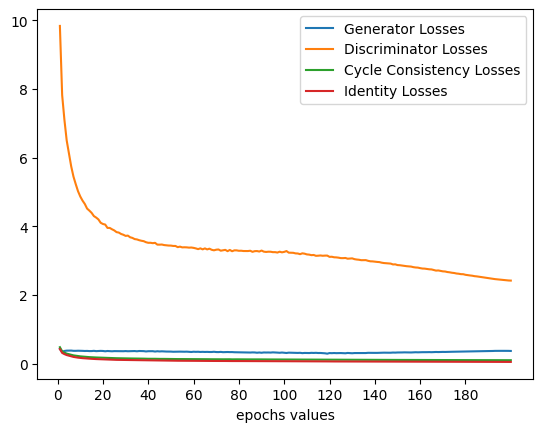

In [ ]:
#plotting
with open("Lossfile","r") as outfile:
    prevData = json.load(outfile)
    saveLoss_G = prevData["G_LOSS"]
    saveLoss_D = prevData["D_LOSS"]
    saveLoss_C = prevData["C_LOSS"]
    saveLoss_I = prevData["I_LOSS"]

epochs = int(len(saveLoss_G))
x = [i+1 for i in range(epochs)]

plt.plot(x, saveLoss_G, label = 'Generator Losses')
plt.plot(x, saveLoss_D, label = 'Discriminator Losses')
plt.plot(x, saveLoss_C, label = 'Cycle Consistency Losses')
plt.plot(x, saveLoss_I, label = 'Identity Losses')
plt.xticks(range(0,epochs, 20))
plt.xlabel('epochs values')
plt.legend()
plt.show()
